# DEPI data with PyTorch in Google Colaboratory

### Aims of this setup

   
The aim is to use Colaboratory, http://colab.research.google.com/ with the GPU runtime (since these give us free access to time on Nvidia K80 cards, up to 12 hours at a time).  

We'll then be able to run each others' models on the real data, evaluate, make changes, and send patches.


 - Your Google Drive should contain:
   - an upload this notebook
   - an upload of the data folder, via:
     - `gsutil -m rsync -r gs://depi-dataset_01 depi`
   
 - The notebook checks out other required sources from Github



### Colaboratory environment

Colaboratory is a proprietary Google fork of Jupyter Notebook, running on their servers.

- We can run shell commands with `!`.
- We can install software with `apt` and `pip`.
- There's a local disk that doesn't persist, under the current directory `/content`
- We can mount Google Drive using FUSE (see below). 
- We can add locally mounted directories to Python's `sys.path` (if we use absolute pathnames, and trailing slashes).

## Accessing files (Google Drive via FUSE)

These tricks to make Google Drive look like an ordinary file system are taken from here:

- https://colab.research.google.com/notebook#fileId=1srw_HFWQ2SMgmWIawucXfusGzrj1_U0q&scrollTo=c99EvWo1s9-x

In [10]:
# Install a Drive FUSE wrapper.
# https://github.com/astrada/google-drive-ocamlfuse
!apt-get install -y -qq software-properties-common python-software-properties module-init-tools
!add-apt-repository -y ppa:alessandro-strada/ppa 2>&1 > /dev/null
!apt-get update -qq 2>&1 > /dev/null
!apt-get -y install -qq google-drive-ocamlfuse fuse

gpg: keybox '/tmp/tmpmbx9zahf/pubring.gpg' created
gpg: /tmp/tmpmbx9zahf/trustdb.gpg: trustdb created
gpg: key AD5F235DF639B041: public key "Launchpad PPA for Alessandro Strada" imported
gpg: Total number processed: 1
gpg:               imported: 1


In [0]:
# Generate auth tokens for Colab
from google.colab import auth
auth.authenticate_user()

In [0]:
# Generate creds for the Drive FUSE library.
from oauth2client.client import GoogleCredentials
creds = GoogleCredentials.get_application_default()
import getpass
!google-drive-ocamlfuse -headless -id={creds.client_id} -secret={creds.client_secret} < /dev/null 2>&1 | grep URL
vcode = getpass.getpass()
!echo {vcode} | google-drive-ocamlfuse -headless -id={creds.client_id} -secret={creds.client_secret}

In [0]:
# Create a directory and mount Google Drive using that directory.
!mkdir -p drive
!google-drive-ocamlfuse drive


fuse: mountpoint is not empty
fuse: if you are sure this is safe, use the 'nonempty' mount option


In [19]:
print('Files in Drive:')
!ls drive/DEPI

# Create a file in Drive.
!echo "This newly created file will appear in your Drive file list." > drive/created.txt

Files in Drive:
deep-embedding	depi


## Downloading source

In [ ]:
#!git clone https://github.com/AI-ON/deep-embedding

!git clone https://github.com/benmoran/deep-embedding@colab

## Installing dependencies

In [6]:
!pip uninstall -y pillow

Uninstalling Pillow-5.0.0:
  Successfully uninstalled Pillow-5.0.0


In [7]:
!pip2 uninstall -y pillow

Cannot uninstall requirement pillow, not installed


In [8]:
!pip3 install http://download.pytorch.org/whl/cu80/torch-0.3.0.post4-cp36-cp36m-linux_x86_64.whl 


In [9]:
!pip install torchvision
!pip install PyDrive
!pip install nibabel

  Using cached Pillow-5.0.0-cp36-cp36m-manylinux1_x86_64.whl


In [18]:
import PIL.TiffImagePlugin # check

AttributeError: ignored

## TODO items

- How long does the DepiDataset step take? Can we time it?
- How to see RAM, GPU memory, CPU, GPU usage? How many cores? Equivalent of `nvidia-smi`?
- Will FUSE-mounted Google Drive be too slow to run Git practically?


# Running a model

In [43]:
# Check we have the Google Drive mount
# We should see deep-embedding source and the depi data.
!ls /content/drive/DEPI

deep-embedding	depi


In [41]:
# We can see running processes using the GPU with nvidia-smi:
!/opt/bin/nvidia-smi

Sun Feb  4 12:27:33 2018       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 375.51                 Driver Version: 375.51                    |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|===============================+======================+======================|
|   0  Tesla K80           Off  | 0000:00:04.0     Off |                    0 |
| N/A   35C    P8    28W / 149W |      2MiB / 11439MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
                                                                               
+-----------------------------------------------------------------------------+
| Processes:                                                       GPU Memory |
|  GPU  

In [44]:
# Clear the Google Drive cache to pick up changes made remotely?
# Not sure if this is necessary.
!google-drive-ocamlfuse -cc

Clearing cache...done


In [0]:
import sys, os
sys.path.append("/content/drive/DEPI/deep-embedding/pytorch/") # Colab has trouble with relative paths here!

In [46]:
a!ls {sys.path[-1]}

depiloader.py  __pycache__  VAE.py


In [48]:
import torch
from torchvision import transforms
from depiloader import DepiDataset, DataLoader, \
  Normalize, ToTensor, AddChannel
import VAE



<module 'VAE' from '/content/drive/DEPI/deep-embedding/pytorch/VAE.py'>

In [0]:
# !google-drive-ocamlfuse -cc

import importlib
importlib.reload(VAE)


In [0]:
dataset = DepiDataset("/content/drive/DEPI/depi/", "4mm", 
		      transform=transforms.Compose([Normalize(),
						    ToTensor(),
						    AddChannel()]))


In [0]:

dataloader = DataLoader(dataset, batch_size=4,
			shuffle=True, num_workers=4)


In [0]:
# Let's get the first batch to check the loader works.
eg_batch = next(iter(dataloader))[0]


In [0]:

CUDA = torch.cuda.is_available()

In [0]:


latent_size = 6
encoder = VAE.MehmetEncoder4mm(eg_batch.shape[2:], latent_size)
decoder = VAE.MehmetDecoder4mm(encoder.latent_size, encoder.last_size)
model = VAE.VAE(encoder, decoder)

if CUDA:
    model.cuda()

optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)    



In [0]:
for epoch in range(100):
  VAE.run_training(dataloader, model, optimizer, epoch=epoch)

Train Epoch: 0 [0/100 (0%)]	LogLik: -103979.593750	KLD: 2.353005	Loss: 103981.945312
====> Epoch: 0 Average loss: 103711.0809
Train Epoch: 1 [0/100 (0%)]	LogLik: -102391.820312	KLD: 4.605109	Loss: 102396.421875
====> Epoch: 1 Average loss: 103646.0275
Train Epoch: 2 [0/100 (0%)]	LogLik: -104228.429688	KLD: 2.990988	Loss: 104231.421875
====> Epoch: 2 Average loss: 103570.6259
Train Epoch: 3 [0/100 (0%)]	LogLik: -103004.968750	KLD: 3.411963	Loss: 103008.382812
====> Epoch: 3 Average loss: 103492.8234
Train Epoch: 4 [0/100 (0%)]	LogLik: -102583.250000	KLD: 3.395750	Loss: 102586.648438
====> Epoch: 4 Average loss: 103415.8750
Train Epoch: 5 [0/100 (0%)]	LogLik: -103832.710938	KLD: 1.910368	Loss: 103834.625000
====> Epoch: 5 Average loss: 103341.9994
Train Epoch: 6 [0/100 (0%)]	LogLik: -102577.195312	KLD: 2.531223	Loss: 102579.726562
====> Epoch: 6 Average loss: 103273.0778
Train Epoch: 7 [0/100 (0%)]	LogLik: -103241.210938	KLD: 1.797369	Loss: 103243.007812
====> Epoch: 7 Average loss: 1032

Process Process-101:
  File "/usr/lib/python3.6/multiprocessing/connection.py", line 407, in _recv_bytes
    buf = self._recv(4)
Process Process-102:
Process Process-103:
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
Process Process-104:
  File "/usr/lib/python3.6/multiprocessing/process.py", line 258, in _bootstrap
    self.run()
  File "/usr/lib/python3.6/multiprocessing/process.py", line 258, in _bootstrap
    self.run()
  File "/usr/lib/python3.6/multiprocessing/process.py", line 258, in _bootstrap
    self.run()
  File "/usr/lib/python3.6/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
  File "/usr/lib/python3.6/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
  File "/usr/lib/python3.6/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
  File "/usr/local/lib/python3.6/dist-packages/torch/utils/data/

KeyboardInterrupt: ignored

In [0]:
recon, mu, logvar = model(data.cuda())

In [0]:
recon[0][0].shape

torch.Size([45, 54, 45])

In [0]:
%matplotlib inline

In [0]:
import matplotlib.pyplot as plt

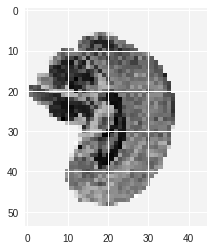

In [0]:
plt.imshow(data[0][0][22].cpu().data.numpy())

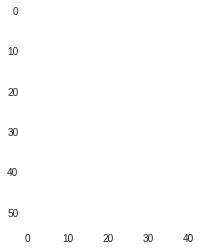

In [0]:
plt.imshow(recon[0][0][22].cpu().data.numpy())